In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [38]:
df = pd.read_csv("framingham.csv")

# List all the feature column names
feature_cols = [
    "male", "age", "education", "currentSmoker", "cigsPerDay", "BPMeds",
    "prevalentStroke", "prevalentHyp", "diabetes", "totChol", "sysBP",
    "diaBP", "BMI", "heartRate", "glucose"
]

df_cleaned = df.dropna()
# print("Any NaN in X:", np.isnan(df).any())

# Extract all features at once
X_train = df_cleaned[feature_cols].values  # Converts to a NumPy array
X_train = np.column_stack([X_train, X_train[:, 0] * X_train[:, 1], X_train[:, 2]**2])


# Extract target variable
y_train = df_cleaned["TenYearCHD"].values  # Converts target column to NumPy array



print(X_train.shape[0])
print(y_train.shape)

print(X_train)

# print("Checking for NaN or Inf in X and y...")
# print("Any NaN in X:", np.isnan(X_train).any())
# print("Any NaN in y:", np.isnan(y_train).any())
# print("Any Inf in X:", np.isinf(X_train).any())
# print("Any Inf in y:", np.isinf(y_train).any())
# print(df.head())

3656
(3656,)
[[  1.  39.   4. ...  77.  39.  16.]
 [  0.  46.   2. ...  76.   0.   4.]
 [  1.  48.   1. ...  70.  48.   1.]
 ...
 [  1.  50.   1. ...  86.  50.   1.]
 [  1.  51.   3. ...  68.  51.   9.]
 [  0.  52.   2. ... 107.   0.   4.]]


In [3]:
# def normalize(X):
#     x_min = X.min(axis=0)
#     x_max = X.max(axis=0)

#     return (X - x_min) / (x_max - x_min)

def normalize(X):
    X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

    return X_scaled

In [44]:
X_train = normalize(X_train)

print(X_train)

[[ 1.11982472 -1.23335117  1.97575158 ... -0.20312694  0.6804393
   2.27007553]
 [-0.8929969  -0.41559058  0.01979497 ... -0.24495595 -0.86986761
  -0.19851345]
 [ 1.11982472 -0.1819447  -0.95818334 ... -0.49592996  1.03820243
  -0.81566069]
 ...
 [ 1.11982472  0.05170118 -0.95818334 ...  0.17333408  1.11770535
  -0.81566069]
 [ 1.11982472  0.16852412  0.99777327 ... -0.57958797  1.15745681
   0.83006529]
 [-0.8929969   0.28534706  0.01979497 ...  1.05174313 -0.86986761
  -0.19851345]]


In [5]:
def sigmoid(z):
    if np.isinf(np.exp(-z).any()):
        print(z)
    g_of_z = 1/(1+np.exp(-z))
    return g_of_z
    

In [6]:
def compute_cost(X, y, w, b, lambda_=1, weight_1=5, *argv):
    m = X.shape[0]
    cost = 0
    epsilon = 1e-10  # Small constant to prevent log(0)

    for i in range(m):
        z_wb_x_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_wb_x_i)

        # Clip f_wb_i to avoid log(0)
        f_wb_i = np.clip(f_wb_i, epsilon, 1 - epsilon)

        if y[i] == 1:
            loss = -weight_1 * np.log(f_wb_i)
        else:
            loss = np.log(1 - f_wb_i)
            
        # loss = -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)
        cost += loss

    return cost / m

In [7]:
print(compute_cost(X_train, y_train, 3, 3))

[-2.52360201 -2.51430576 -2.57694055 -2.56500053 -2.51763453 -2.45631541
 -2.42733651 -2.42361494 -2.4514277  -2.54414467 -2.42835133 -2.45738816
 -2.52236595 -2.5788566  -2.41531602]


In [8]:
def compute_gradient(X, y, w, b, lambda_, beta = 5, *argv):
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        z_wb_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_wb_i)
        err = f_wb_i - y[i]

        weight = beta if y[i] == 1 else 1 
        for j in range(n):
            dj_dw[j] += weight * err * X[i][j]
        dj_db += weight * err

    return dj_dw, dj_db
            

In [57]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_ = 1): 
    w = w_in.copy()
    b = b_in

    J_history = []
    w_history = []

    # for i in range(num_iters):
    #     dj_dw, dj_db = gradient_function(X, y, w, b, lambda_)

    #     w = w - alpha * dj_dw
    #     b = b - alpha * dj_db

    v_dw = np.zeros_like(w)
    beta_momentum = 0.9  # Momentum coefficient

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_reg(X, y, w, b, lambda_)
        
        v_dw = beta_momentum * v_dw + (1 - beta_momentum) * dj_dw  # Update with momentum
        w = w - alpha * v_dw
        b = b - alpha * dj_db


        cost = cost_function(X, y, w, b, lambda_)

        if i % 100 == 0:
            print(cost)

        J_history.append(cost)

    return w, b, J_history

In [10]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    cost = compute_cost(X, y, w, b)

    m, n = X.shape
    reg_cost = 0

    for j in range(n):
        reg_cost += w[j] ** 2

    reg_cost = reg_cost * (lambda_ / (2 * m))

    total_cost = reg_cost + cost

    return total_cost

In [41]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1, beta=5):
    dj_dw, dj_db = compute_gradient(X, y, w, b, lambda_, beta)

    m,n = X.shape

    for j in range(n):
        dj_dw[j] += (lambda_ / m) * w[j]

    return dj_dw, dj_db


In [58]:
w_in = np.zeros(X_train.shape[1])
b_in = 0.
alpha = 0.001
lambda_ = 0.01

# w, b, J_history = gradient_descent(X_train, y_train, w_in, b_in, compute_cost, compute_gradient, alpha, 1000)
w, b, J_history = gradient_descent(X_train, y_train, w_in, b_in, compute_cost_reg, compute_gradient_reg, alpha, 200, lambda_)


print(w, b)

-0.003898867858012504
0.01856858487633322
[ 0.09179708  0.52542643 -0.41521027  0.06661049  0.20550252  0.04281004
  0.0507856   0.11445817  0.0224065   0.10792047  0.31610192 -0.03667459
  0.03549317 -0.03629045  0.13888708  0.15694899  0.34617427] -0.3849439163028156


In [78]:
def predict(X, w, b):
    m = X.shape[0]
    p = np.zeros((m,))


    for i in range(m):
        z_wb_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_wb_i)

        if f_wb_i >= 0.5:
            # print(f_wb_i)
            p[i] = 1
        else:
            p[i] = 0

    return p

    

In [79]:
def compare_with_actual_values(p, y):
    m = p.shape[0]

    y_length = y.shape[0]
    got_correct = 0
    for i in range(m):
        # print(p[i])
        if p[i] == y[i]:
            got_correct += 1
        # else:
            # print(p[i], y[i])

    return f"Number of examples: {y_length}, got correct: {got_correct}."

In [80]:
def ratio_of_ones_to_examples(y):
    count = 0
    
    for number in y:
        if number == 1:
            count += 1

    return count / y.shape[0]

In [81]:
p = predict(X_train, w, b)
print(compare_with_actual_values(p, y_train))

Number of examples: 3656, got correct: 2595.


In [82]:
print(ratio_of_ones_to_examples(y_train))

0.15235229759299782


In [83]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train, p)
print(conf_matrix)


[[2231  868]
 [ 193  364]]


In [182]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, p)
recall = recall_score(y_train, p)
f1 = f1_score(y_train, p)

print(f"Precision: {precision:.4f}")  # How many predicted 1s were correct?
print(f"Recall: {recall:.4f}")  # How many actual 1s did we catch?
print(f"F1 Score: {f1:.4f}")  # Balance between precision and recall


Precision: 0.3883
Recall: 0.2873
F1 Score: 0.3302


In [183]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for t in thresholds:
    preds = (sigmoid(np.dot(X_train, w) + b) >= t).astype(int)
    print(f"Threshold {t}: Precision = {precision_score(y_train, preds):.4f}, Recall = {recall_score(y_train, preds):.4f}, F1 = {f1_score(y_train, preds):.4f}")


Threshold 0.3: Precision = 0.3883, Recall = 0.2873, F1 = 0.3302
Threshold 0.4: Precision = 0.4602, Recall = 0.1454, F1 = 0.2210
Threshold 0.5: Precision = 0.7302, Recall = 0.0826, F1 = 0.1484
Threshold 0.6: Precision = 0.8421, Recall = 0.0287, F1 = 0.0556
Threshold 0.7: Precision = 0.8571, Recall = 0.0108, F1 = 0.0213


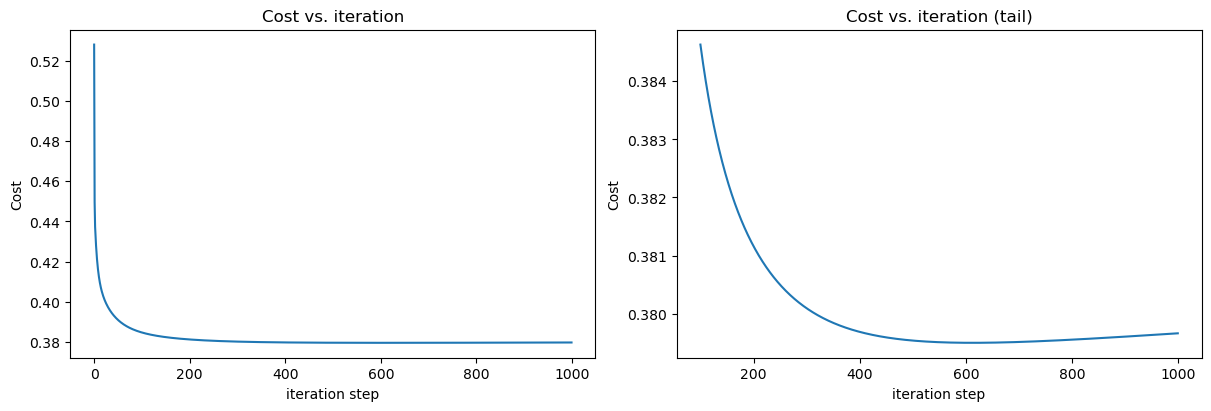

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_history)
ax2.plot(100 + np.arange(len(J_history[100:])), J_history[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [70]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print("Sklearn accuracy:", model.score(X_train, y_train))


Sklearn accuracy: 0.8544857768052516


In [17]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)

In [29]:
print(X_train[:, :2])

l = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

print(l[:2][:1])

[[1.         0.18421053]
 [0.         0.36842105]
 [1.         0.42105263]
 ...
 [1.         0.47368421]
 [1.         0.5       ]
 [0.         0.52631579]]
[[1, 2, 3]]


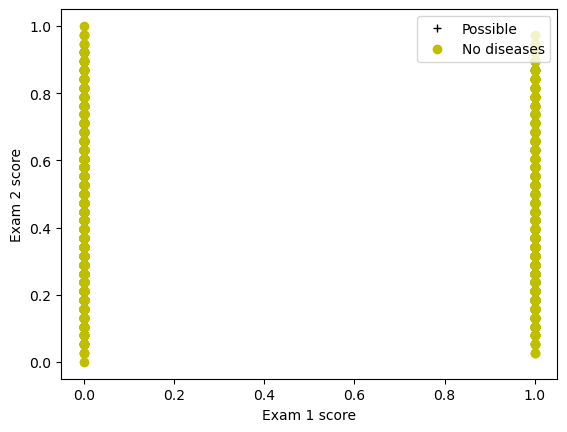

In [31]:
# Plot examples
plot_data(X_train[:, :2], y_train[:], pos_label="Possible", neg_label="No diseases")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")
plt.show()


In [32]:
def plot_decision_boundary(w, b, X, y):
    # Plot data points
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', c='r', marker='x')
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', c='g', marker='o')

    # Plot decision boundary
    x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
    x_values = np.linspace(x_min, x_max, 100)
    y_values = -(w[0] * x_values + b) / w[1]

    plt.plot(x_values, y_values, label='Decision Boundary', color='blue')
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.title('Decision Boundary')
    plt.show()


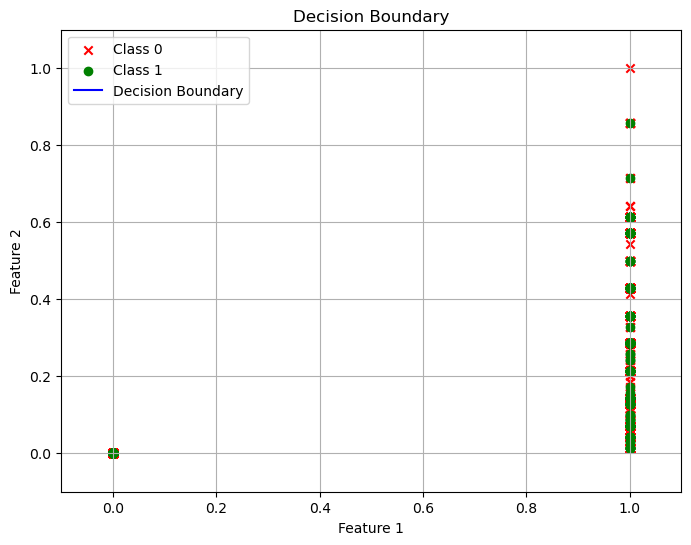

In [35]:
plot_decision_boundary(w, b, X_train[:, 3:5], y_train)